In [1]:
from yahoo_fin import stock_info as si
import pandas as pd
import numpy as np
import requests_html
import datetime
import seaborn as sns
from scipy import stats
from dateutil import parser

from yahoo_fin import options


In [2]:
def get_bid_price(ticker):
    bid = float(si.get_quote_table(ticker, dict_result = True)['Bid'].split("x")[0].replace(',',''))
    return bid

def get_ask_price(ticker):
    ask = float(si.get_quote_table(ticker, dict_result = True)['Ask'].split("x")[0].replace(',',''))
    return ask

def get_spread(ticker):
    spread = round(get_ask_price(ticker)-get_bid_price(ticker),3)
    return abs(spread)

def ticker_df(ticker,date1,date2):
    date1 = str(date1)
    date2 = str(date2)
    df = si.get_data(ticker, start_date=date1, end_date=date2)
    print('df:', len(df), 'list:', len(list(df.T)))
    df['date'] = list(df.T)
    return df

def get_nearest_rows(df,col_name,value):
    col_values = list(df[col_name])
    col_diff = np.array(col_values)-value
    abs_col_diff = [abs(i) for i in col_diff]
    min_diff = min(abs_col_diff)
    index_list = abs_col_diff.index(min_diff)
    print(index_list)
    df = pd.DataFrame(df.iloc[index_list])
    return df.T

In [3]:
def col_percentile(df,col,perc):
    col = np.array(df[col].dropna())
    perc = np.percentile(col,68)
    return perc

def empty_detect(df,function,params):
    df_dom = function(df,*params)
    if len(df_dom) == 0:
        return 'nan'
    else:
        return df_dom

def wait_diff(least_ts,ts):
    if least_ts=='nan':
        return 'nan'
    else:
        return least_ts-ts

def convert_col_time(df,ts_col):
    if isinstance(df, str):
        return 'nan'
    else:
        df.to_csv(r'Documents/test.csv')
        df[ts_col]= pd.to_datetime(df[ts_col])
        return df
       
def get_dominating_tss(df,ts_col,pri_col,sec_col,ts,spread):
    df[ts_col]= pd.to_datetime(df[ts_col]) 
    price_now = float(df[df[ts_col]==ts][pri_col])
    df_dom = df[(df[ts_col]>=ts)&((df[sec_col]>=price_now+spread)|(df[sec_col]<=price_now-spread))]
    return df_dom

def get_dominating_tss_overlay(df,ts_col,pri_col,sec_col,ts,spread,ol_up,ol_dn):
    df[ts_col]= pd.to_datetime(df[ts_col]) 
    price_now = float(df[df[ts_col]==ts][pri_col])
    df_dom = df[(df[ts_col]>=ts)&((df[sec_col]>=price_now+spread+ol_up)|(df[sec_col]<=price_now-spread-ol_dn))]
    return df_dom



def get_least_tss(df,ts_col):
    if isinstance(df, str):
        return 'nan'
    else:
        ts_list=list(df[ts_col])
        least_ts = min(ts_list)
        return least_ts

def get_wait_time(df,ts_col,pri_col,sec_col,ts,spread):
    df_dom = empty_detect(df,get_dominating_tss,(ts_col,pri_col,sec_col,ts,spread))
    df_dom = convert_col_time(df_dom,ts_col)
    least_ts = get_least_tss(df_dom,ts_col)
    wait_time = wait_diff(least_ts,ts)
    return wait_time

def get_wait_time_overlay(df,ts_col,pri_col,sec_col,ts,spread,ol_up,ol_dn):
    df_dom = empty_detect(df,get_dominating_tss_overlay,(ts_col,pri_col,sec_col,ts,spread,ol_up,ol_dn))
    df_dom = convert_col_time(df_dom,ts_col)
    least_ts = get_least_tss(df_dom,ts_col)
    wait_time = wait_diff(least_ts,ts)
    return wait_time



def add_wait_col(ticker,date1,date2,ts_col,pri_col,sec_col):
    df = ticker_df(ticker,date1,date2)
    ticker = list(df['ticker'])[0]
    print(ticker)
    #spread = get_spread(ticker)
    #print("spread: ",spread)
    df['Wait_Time']=df.apply(lambda row:get_wait_time(df,ts_col,pri_col,sec_col,row[ts_col],abs(row['open']-row['close'])),axis=1)
    df['Wait_Time']=df.apply(lambda row:float(row['Wait_Time'].days),axis=1)
    df['Spread']=df.apply(lambda row:abs(row['open']-row['close']),axis=1)
    df['Upper_Bnd'] = df.apply(lambda row: row['adjclose']+row['Spread'],axis=1)
    df['Lower_Bnd'] = df.apply(lambda row: max(row['adjclose']-row['Spread'],0),axis=1)
    return df

def add_wait_col_overlay(ticker,date1,date2,ts_col,pri_col,sec_col,ol_up,ol_dn):
    df = ticker_df(ticker,date1,date2)
    ticker = list(df['ticker'])[0]
    print(ticker)
    #spread = get_spread(ticker)
    #print("spread: ",spread)
    df['Wait_Time']=df.apply(lambda row:get_wait_time_overlay(df,ts_col,pri_col,sec_col,row[ts_col],abs(row['open']-row['close']),ol_up,ol_dn),axis=1)
    df['Wait_Time']=df.apply(lambda row:float(row['Wait_Time'].days),axis=1)
    df['Spread']=df.apply(lambda row:abs(row['open']-row['close']),axis=1)
    df['Upper_Bnd'] = df.apply(lambda row: row['adjclose']+row['Spread'],axis=1)
    df['Lower_Bnd'] = df.apply(lambda row: max(row['adjclose']-row['Spread'],0),axis=1)
    return df

def wait_hist(df,col1):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.distplot(df[col1].dropna())
    return None

def get_eff_bounds(ticker,date1,date2):
    today = datetime.date.today().strftime("%m/%d/%y")
    df1 = add_wait_col(ticker,date1,date2,'date','adjclose','adjclose')
    upper_bnd = list(df1['Upper_Bnd'])[2]
    lower_bnd = list(df1['Lower_Bnd'])[2]
    exp_dates = options.get_expiration_dates(ticker)
    #print(exp_dates[1])
    chain = options.get_options_chain(ticker,exp_dates[2])
    #print(list(chain['calls']))
    calls = chain['calls']  
    puts = chain['puts']
    call_ask = float(get_nearest_rows(calls,'Strike',upper_bnd)['Ask'])
    call_strike = float(get_nearest_rows(calls,'Strike',upper_bnd)['Strike'])
    call_contract = str(get_nearest_rows(calls,'Strike',upper_bnd)['Contract Name'])
    #print(get_nearest_rows(puts,'Strike',lower_bnd)['Ask'])
    put_ask = float(get_nearest_rows(puts,'Strike',lower_bnd)['Ask'])
    put_strike = float(get_nearest_rows(puts,'Strike',lower_bnd)['Strike'])
    put_contract = str(get_nearest_rows(puts,'Strike',lower_bnd)['Contract Name'])
    eff_upper_bnd = upper_bnd + call_ask
    eff_lower_bnd = lower_bnd - put_ask
    #time_to_expiry = datetime.datetime.strptime(exp_dates[1], "%B %d, %y")-datetime.date.today()
    exp_date = exp_dates[2]  # datetime.datetime(1999, 8, 28, 0, 0)
    #time_to_expiry = exp_date-datetime.date.today()
    eff_dict = {'Upper_Bnd':upper_bnd,'Lower_Bnd':lower_bnd,'Eff_upper':eff_upper_bnd,'Eff_lower':eff_lower_bnd,'ID_call':call_contract,'Strike_call':call_strike,'Call':call_ask,'ID_put':put_contract,'Strike_put':put_strike,'Put':put_ask,'Expiry':exp_date,'Total_Straddle_Cost':call_ask+put_ask}
    return eff_dict

def pipeline1(date1,date2):
    percentiles={}
    for ticker in sp500:
        try:
            df1=add_wait_col(ticker,date1,date2,'date','adjclose','adjclose')
            latest_price = list(df1['adjclose'])[-1]
            upper_bnd = list(df1['Upper_Bnd'])[-1]
            lower_bnd = list(df1['Lower_Bnd'])[-1]
            perc = col_percentile(df1,'Wait_Time',69)
            pair = {ticker:{'Curr_Price':latest_price,'Upper_Bnd':upper_bnd,'Lower_Bnd':lower_bnd,'Percentile':perc,'Mean':np.mean(df1['Wait_Time']),'Std':np.std(df1['Wait_Time'])}}
            percentiles.update(pair)
        
        except:
            print(ticker,"failed")
            pair = {ticker:{'Percentile':'nan','Mean':'nan','Std':'nan'}}
            continue
    return percentiles

def pipeline2(date1,date2):
    eff_bounds = {}
    for ticker in sp500:
            try:
                info = get_eff_bounds(ticker,date1,date2)
                pair  = {ticker:info}
                eff_bounds.update(pair)
                df = pd.DataFrame(eff_bounds).T
                df = df.sort_values('Total_Straddle_Cost',ascending=True)
            except Exception as e:
                print(ticker,"failed",e)
            continue
    return df



In [8]:
sp500=['ABT', 'ABBV','ACN', 'ACE', 'ADBE', 'ADT', 'AAP', 'AES', 'AET', 'AFL', 'AMG', 'A', 'GAS', 'APD', 'ARG', 'AKAM', 'AA', 'AGN', 'ALXN', 'ALLE', 'ADS', 'ALL', 'ALTR', 'MO', 'AMZN', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'APC', 'ADI', 'AON', 'APA', 'AIV', 'AMAT', 'ADM', 'AIZ', 'T', 'ADSK', 'ADP', 'AN', 'AZO', 'AVGO', 'AVB', 'AVY', 'BHI', 'BLL', 'BAC', 'BK', 'BCR', 'BXLT', 'BAX', 'BBT', 'BDX', 'BBBY', 'BRK-B', 'BBY', 'BLX', 'HRB', 'BA', 'BWA', 'BXP', 'BSK', 'BMY', 'BRCM', 'BF-B', 'CHRW', 'CA', 'CVC', 'COG', 'CAM', 'CPB', 'COF', 'CAH', 'HSIC', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNP', 'CTL', 'CERN', 'CF', 'SCHW', 'CHK', 'CVX', 'CMG', 'CB', 'CI', 'XEC', 'CINF', 'CTAS', 'CSCO', 'C', 'CTXS', 'CLX', 'CME', 'CMS', 'COH', 'KO', 'CCE', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CSC', 'CAG', 'COP', 'CNX', 'ED', 'STZ', 'GLW', 'COST', 'CCI', 'CSX', 'CMI', 'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DE', 'DLPH', 'DAL', 'XRAY', 'DVN', 'DO', 'DTV', 'DFS', 'DISCA', 'DISCK', 'DG', 'DLTR', 'D', 'DOV', 'DOW', 'DPS', 'DTE', 'DD', 'DUK', 'DNB', 'ETFC', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'EMC']#, 'EMR', 'ENDP', 'ESV', 'ETR', 'EOG', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ES', 'EXC', 'EXPE', 'EXPD', 'ESRX', 'XOM', 'FFIV', 'FB', 'FAST', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FSIV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FTI', 'F', 'FOSL', 'BEN', 'FCX', 'FTR', 'GME', 'GPS', 'GRMN', 'GD', 'GE', 'GGP', 'GIS', 'GM', 'GPC', 'GNW', 'GILD', 'GS', 'GT', 'GOOGL', 'GOOG', 'GWW', 'HAL', 'HBI', 'HOG', 'HAR', 'HRS', 'HIG', 'HAS', 'HCA', 'HCP', 'HCN', 'HP', 'HES', 'HPQ', 'HD','HON', 'HRL', 'HSP', 'HST', 'HCBK', 'HUM', 'HBAN', 'ITW', 'IR', 'INTC', 'ICE', 'IBM', 'IP', 'IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IRM', 'JEC', 'JBHT', 'JNJ', 'JCI', 'JOY', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'GMCR', 'KMB', 'KIM'. 'KMI', 'KLAC', 'KSS', 'KRFT', 'KR', 'LB', 'LLL', 'LH', 'LRCX', 'LM', 'LEG', 'LEN', 'LVLT', 'LUK', 'LLY', 'LNC', 'LLTC', 'LMT', 'L', 'LOW', 'LYB', 'MTB', 'MAC', 'M', 'MNK', 'MRO', 'MPC', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MAT', 'MKC', 'MCD', 'MHFI', 'MCK', 'MJN', 'MMV', 'MDT', 'MRK', 'MET', 'KORS', 'MCHP', 'MU', 'MSFT', 'MHK', 'TAP', 'MDLZ', 'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MUR', 'MYL', 'NDAQ', 'NOV', 'NAVI', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NEE', 'NLSN', 'NKE', 'NI', 'NE', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NRG', 'NUE', 'NVDA', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'OI', 'PCAR', 'PLL', 'PH', 'PDCO', 'PAYX', 'PNR', 'PBCT', 'POM', 'PEP', 'PKI', 'PRGO', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PBI', 'PCL', 'PNC', 'RL', 'PPG', 'PPL', 'PX', 'PCP', 'PCLN', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RRC', 'RTN', 'O', 'RHT', 'REGN', 'RF', 'RSG', 'RAI', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RLC', 'R', 'CRM', 'SNDK', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SRE', 'SHW', 'SIAL', 'SPG', 'SWKS', 'SLG', 'SJM', 'SNA', 'SO', 'LUV', 'SWN', 'SE', 'STJ', 'SWK', 'SPLS', 'SBUX', 'HOT', 'STT', 'SRCL', 'SYK', 'STI', 'SYMC', 'SYY', 'TROW', 'TGT', 'TEL', 'TE', 'TGNA', 'THC', 'TDC', 'TSO', 'TXN', 'TXT', 'HSY', 'TRV', 'TMO', 'TIF', 'TWX', 'TWC', 'TJK', 'TMK', 'TSS', 'TSCO', 'RIG', 'TRIP', 'FOXA', 'TSN', 'TYC', 'UA', 'UNP', 'UNH', 'UPS', 'URI', 'UTX', 'UHS', 'UNM', 'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VZ', 'VRTX', 'VIAB', 'V', 'VNO', 'VMC', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'ANTM', 'WFC', 'WDC', 'WU', 'WY', 'WHR', 'WFM', 'WMB', 'WEC', 'WYN', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZBH', 'ZION', 'ZTS']
#sp500=['ABT']

In [9]:
date1='01/01/2019'
date2='08/25/2020'

In [ ]:
df = pipeline2(date1,date2)

In [20]:
df.head(10)

,Upper_Bnd,Lower_Bnd,Eff_upper,Eff_lower,ID_call,Strike_call,Call,ID_put,Strike_put,Put,Expiry,Total_Straddle_Cost
APD,159.8,152.72,159.8,152.72,"2 APD201218C00160000\nName: Contract Name, ...",160,0,"7 APD201218P00155000\nName: Contract Name, ...",155,0,"December 18, 2020",0
AZO,851.39,819.87,851.39,819.87,"13 AZO200918C00860000\nName: Contract Name,...",860,0,"23 AZO200918P00820000\nName: Contract Name,...",820,0,"September 18, 2020",0
DVN,23.6956,22.8356,23.6956,22.8356,"23 DVN200918C00018000\nName: Contract Name,...",18,0,"21 DVN200918P00016000\nName: Contract Name,...",16,0,"September 18, 2020",0
AVY,89.9742,85.6142,89.9742,85.6142,"0 AVY201218C00095000\nName: Contract Name, ...",95,0,"4 AVY201218P00085000\nName: Contract Name, ...",85,0,"December 18, 2020",0
DO,10.9,10.7,10.9,10.7,"5 DO210115C00010000\nName: Contract Name, d...",10,0,"3 DO210115P00010000\nName: Contract Name, d...",10,0,"January 15, 2021",0
CMA,67.326,65.4861,67.726,65.4861,"21 CMA210115C00067500\nName: Contract Name,...",67.5,0.4,"20 CMA210115P00065000\nName: Contract Name,...",65,0,"January 15, 2021",0.4
DHR,101.574,97.8741,101.574,97.4441,"0 DHR201218C00140000\nName: Contract Name, ...",140,0,"0 DHR201218P00100000\nName: Contract Name, ...",100,0.43,"December 18, 2020",0.43
A,65.9755,63.2355,65.9755,62.7355,"3 A201120C00067500\nName: Contract Name, dt...",67.5,0,"6 A201120P00062500\nName: Contract Name, dt...",62.5,0.5,"November 20, 2020",0.5
CCI,103.646,102.106,103.646,101.206,"7 CCI210115C00105000\nName: Contract Name, ...",105,0,"10 CCI210115P00100000\nName: Contract Name,...",100,0.9,"January 15, 2021",0.9
CHK,2.29,2.21,2.29,1.17,"4 CHK210115C00002500\nName: Contract Name, ...",2.5,0,3 CHKAQ210115P00002000\nName: Contract Name...,2,1.04,"January 15, 2021",1.04


df: 292 list: 292
CCI


/Users/sagarkolte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



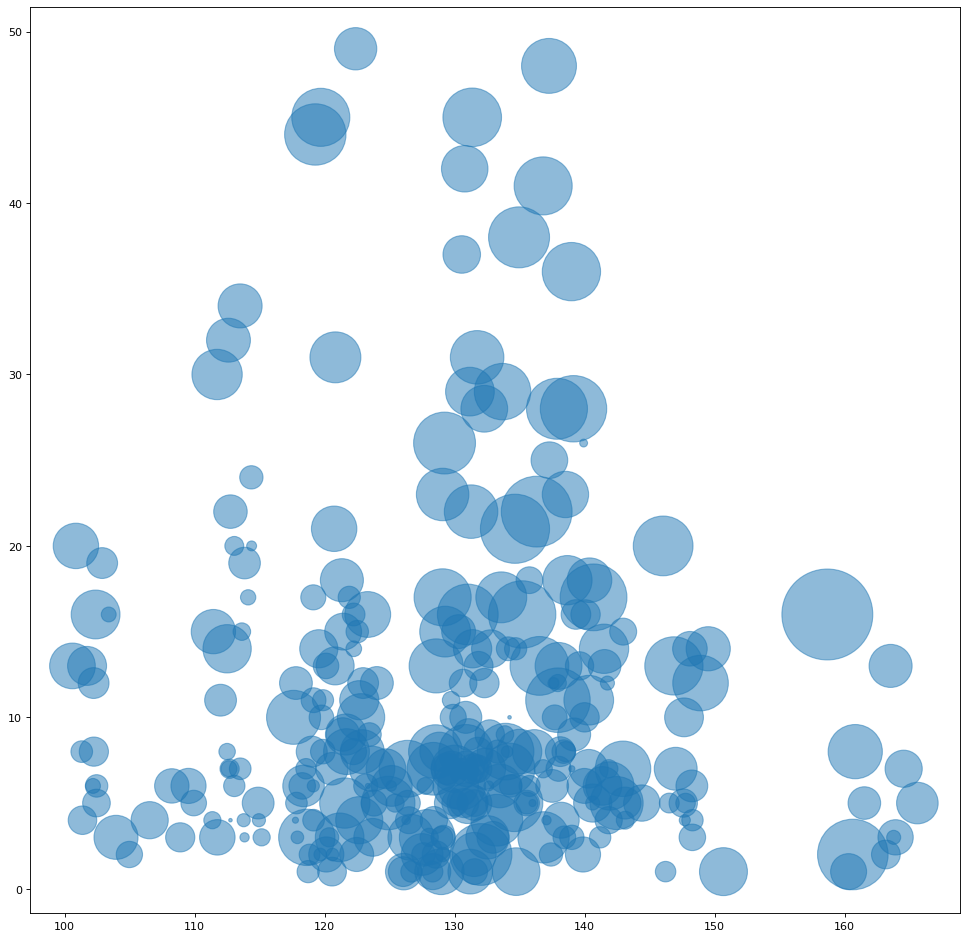

In [26]:
import plotly.express as px
import matplotlib.pyplot as plt
date1='01/01/2019'
date2='03/01/2020'
df1 = add_wait_col_overlay('cci',date1,date2,'date','adjclose','adjclose',1.23,3.70)


plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(df1['adjclose'], df1['Wait_Time'], s=df1['Spread']*1000, alpha=0.5)


plt.show()


APD: Expect this to go below 250 but stay above 200
AZO: Sideways/No Expectations
DVN: Expect this to rise above 15 but stay below 27
AVY: Sideways/No Expectations
CMA: Expect this to rise above 55 but stay below 75
DHR: This is a Medical Industry Company, scatter plot does not represent true value of the corp. Expect this to be around the 180 mark.
A: We expect that the vaulation of the company has changed over the pandemic due to its connections to lab equipments

